In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
!nvidia-smi

Tue Feb 16 08:48:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 29%   42C    P2    30W / 250W |   1179MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

loss        0.006355
val_loss    0.040687
dtype: float64


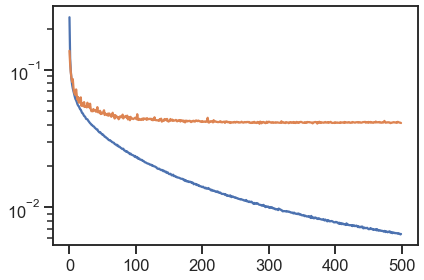

In [3]:
log = pd.read_csv('20210214_redox_original_data/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)

print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp
nfp.__version__

'0.2.0'

In [6]:
from preprocessor import preprocessor

from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20210214_redox_original_data/best_model.hdf5',
    custom_objects=nfp.custom_objects)

In [23]:
new_model = tf.keras.Model(model.inputs[:3], model.outputs)
new_model.save('/projects/rlmolecule/pstjohn/models/20210214_redox/', include_optimizer=False)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /projects/rlmolecule/pstjohn/models/20210214_redox/assets


In [8]:
tf.keras.models.load_model('/projects/rlmolecule/pstjohn/models/20210214_redox/', compile=False)

In [9]:
from train_model_redox import parse_example

In [10]:
redox_df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')
data = np.load('redox_split.npz', allow_pickle=True)
redox_valid = redox_df[redox_df.smiles.isin(np.concatenate([data['valid'], data['test']]))]

In [11]:
redox_valid.shape

(2000, 5)

In [12]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [13]:
predicted_redox = model.predict(test_dataset, verbose=1)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


16/16 [==============================] - 1s 68ms/step


Text(0.5, 1.0, 'electron affinity')

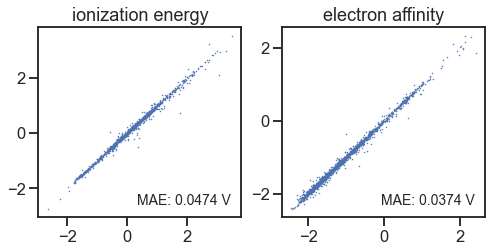

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3.5))
axs[0].plot(redox_valid['ionization energy'], predicted_redox[:, 0], '.', ms=1)
axs[1].plot(redox_valid['electron affinity'], predicted_redox[:, 1], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_valid['ionization energy'] - predicted_redox[:, 0]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_valid['electron affinity'] - predicted_redox[:, 1]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('ionization energy')
axs[1].set_title('electron affinity')

In [15]:
redox_valid = redox_valid.copy()
redox_valid['pred ionization energy'] = predicted_redox[:, 0]
redox_valid['pred electron affinity'] = predicted_redox[:, 1]

In [16]:
redox_valid['err ionization energy'] = (redox_valid['pred ionization energy'] - redox_valid['ionization energy']).abs()
redox_valid['err electron affinity'] = (redox_valid['pred electron affinity'] - redox_valid['electron affinity']).abs()

In [17]:
redox_valid['err ionization energy'].dropna().mean()

0.04738907335529841

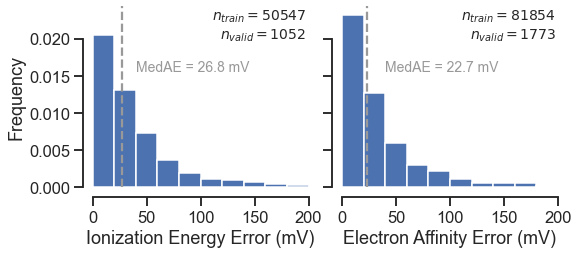

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharey=True, sharex=True)

axs[0].hist(redox_valid['err ionization energy'] * 1000, range=(0, 200), density=True)
axs[1].hist(redox_valid['err electron affinity'] * 1000, range=(0, 200), density=True)

axs[0].text(.99, .99, f"$n_{{train}} = {len(redox_df[redox_df.smiles.isin(data['train'])]['ionization energy'].dropna())}$\n$n_{{valid}} = {len(redox_valid['err ionization energy'].dropna())}$",
            transform=axs[0].transAxes,
            ha='right', va='top', fontsize=14)

axs[1].text(.99, .99, f"$n_{{train}} = {len(redox_df[redox_df.smiles.isin(data['train'])]['electron affinity'].dropna())}$\n$n_{{valid}} = {len(redox_valid['err electron affinity'].dropna())}$",
            transform=axs[1].transAxes,
            ha='right', va='top', fontsize=14)

med_ae = 1000*redox_valid['err ionization energy'].median()
axs[0].axvline(med_ae, ls='--', color='.6')
axs[0].text(.2, .7, f"MedAE = {med_ae:.1f} mV",
            transform=axs[0].transAxes,
            ha='left', va='top', fontsize=14, color='.6')

axs[1].axvline(1000*redox_valid['err electron affinity'].median(), ls='--', color='.6')
med_ae = 1000*redox_valid['err electron affinity'].median()
axs[1].text(.2, .7, f"MedAE = {med_ae:.1f} mV",
            transform=axs[1].transAxes,
            ha='left', va='top', fontsize=14, color='.6')

axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Ionization Energy Error (mV)')
axs[1].set_xlabel('Electron Affinity Error (mV)')

axs[0].set_xlim([0, 200])

plt.tight_layout()
sns.despine(trim=True, offset=10)

In [ ]:
spins = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins_expanded.csv.gz')

In [ ]:
spins['fractional_spin'] = spins.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

In [ ]:
max_fractional_spin = spins.groupby('smiles').fractional_spin.max()

In [ ]:
redox_valid_spin = redox_valid.join(max_fractional_spin, on='smiles')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True, sharex=True)
axs[0].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err ionization energy'], '.', ms=2.5)
axs[0].axhline(0.025, ls='--', color='.8')
axs[1].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err electron affinity'], '.', ms=2.5)
axs[1].axhline(0.025, ls='--', color='.8')

axs[0].set_ylabel('Error')
axs[0].set_xlabel('Max fractional spin')
axs[1].set_xlabel('Max fractional spin')

axs[0].set_title('Ionization Energy')
axs[1].set_title('Electron Affinity')

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True, sharex=True)
# axs[0].semilogy(redox_valid_spin['oxidized_rms'], redox_valid_spin['err ionization energy'], '.', ms=2.5)
# axs[0].axhline(0.025, ls='--', color='.8')
# axs[1].semilogy(redox_valid_spin['reduced_rms'], redox_valid_spin['err electron affinity'], '.', ms=2.5)
# axs[1].axhline(0.025, ls='--', color='.8')

# axs[0].set_ylabel('Error')
# axs[0].set_xlabel('RMS')
# axs[1].set_xlabel('RMS')

# axs[0].set_title('Ionization Energy')
# axs[1].set_title('Electron Affinity')

In [ ]:
ie_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.75].sort_values('err ionization energy', ascending=False).head(3)
ea_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.70].sort_values('err electron affinity', ascending=False).head(3)

In [ ]:
import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    redf = pd.read_sql_query("""
    SELECT * from redoxcompound where status='finished'
    """, conn)

In [ ]:
ie_outliers[['smiles', 'ionization energy', 'pred ionization energy', 'fractional_spin']]  # oxidized

In [ ]:
ea_outliers[['smiles', 'electron affinity', 'pred electron affinity', 'fractional_spin']] 

In [ ]:
ie_logs = redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].logfile
ea_logs = redf[redf.smiles.isin(ea_outliers.smiles) & redf.estate.isin(('radical', 'reduced'))].logfile

In [ ]:
# redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].sort_values(['smiles', 'estate'])

In [ ]:
import shutil

In [ ]:
for log in ie_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200918_outliers/ie')

In [ ]:
for log in ea_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200918_outliers/ea')

In [ ]:
log

In [ ]:
import os


In [ ]:
ie_logs

In [ ]:
ie_logs.apply(os.path.basename)